# Important: Get kagggle.json before running the notebook
Follow [these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get a kaggle.json key file. Then upload it to colab using the follow script.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
#@title Setup for colab { display-mode: "form" }

%%capture
!sudo apt-get install subversion
!svn checkout https://github.com/probml/pyprobml/trunk/scripts/vae .
!pip install pytorch-lightning einops
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!rm kaggle.json
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/two_stage_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/hinge_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/info_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/logcosh_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/mmd_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vanilla_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/sigma_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt

**Warning**: If you are running this on your local machine please follow the readme instructions to first download the subdirectory before using this notebook, instead of running the "setup for colab" file.

In [4]:
#@title Run Setup And Installation { display-mode: "form" }

import torch
import warnings
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from download_celeba import celeba_dataloader
from assembler import get_config, assembler
from utils.plot import plot_reconstruction, plot_samples
from utils.interpolation import vector_of_interest, get_imrange

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_model(model_name, use_gpu=False):
  fname = f"./configs/{model_name}.yaml"
  config = get_config(fname)
  vae = assembler(config, "inference")
  if use_gpu: vae = vae.to("cuda")
  return vae

def make_and_load_models(model_names: list, use_gpu=False):
  vaes = []
  for model_name in model_names:
    vae = make_model(model_name, use_gpu)
    vae.load_model()
    vaes.append(vae)
  return vaes 

# Download data and load data module

In [5]:
#@title Download celeba and load datamodule { display-mode: "form" }
!python download_celeba.py

bs = 512
IMAGE_SIZE = 64
CROP = 128
lr = 1e-3
epochs= 1
latent_dim = 256
DATA_PATH = "kaggle"

dm = celeba_dataloader(bs, IMAGE_SIZE, CROP, DATA_PATH)

dm.setup() # force make data loaders n

batch = next(iter(dm.train_dataloader()))
x, y = batch 

 99% 1.32G/1.33G [00:08<00:00, 189MB/s]
100% 1.33G/1.33G [00:08<00:00, 159MB/s]
  0% 0.00/2.02M [00:00<?, ?B/s]
100% 2.02M/2.02M [00:00<00:00, 183MB/s]
  0% 0.00/1.54M [00:00<?, ?B/s]
100% 1.54M/1.54M [00:00<00:00, 243MB/s]
  0% 0.00/466k [00:00<?, ?B/s]
100% 466k/466k [00:00<00:00, 275MB/s]
  0% 0.00/2.07M [00:00<?, ?B/s]
100% 2.07M/2.07M [00:00<00:00, 191MB/s]
Done!
I0815 13:18:17.372500 140035072063360 utils.py:157] NumExpr defaulting to 2 threads.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)

# Comparing results

In [6]:
models_to_compare = ["vanilla_vae", "info_vae", "hinge_vae", "mmd_vae", "logcosh_vae", "two_stage_vae", "sigma_vae", "vq_vae"]
figsize_reconstruction = (10, 30)
figsize_samples = (10, 10)

vaes = make_and_load_models(models_to_compare, use_gpu = True)

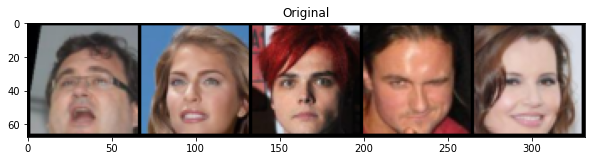

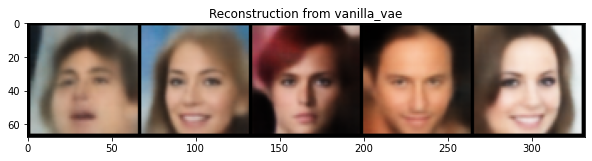

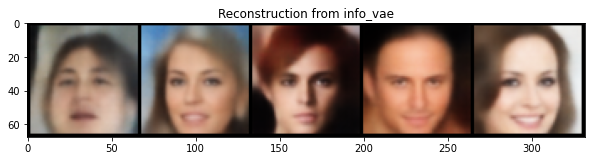

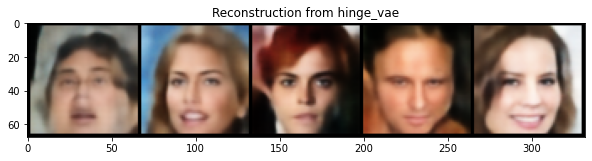

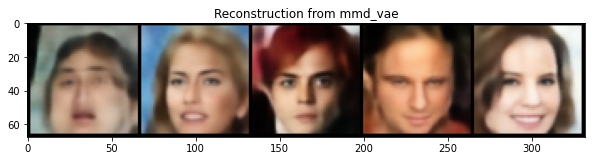

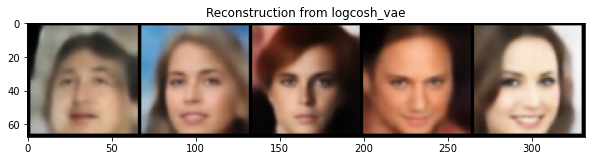

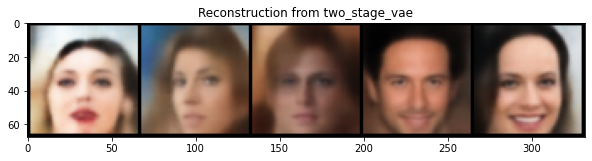

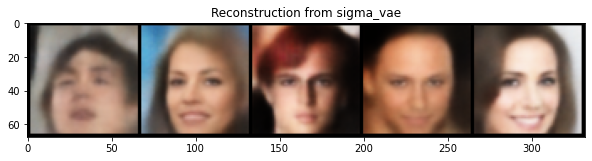

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


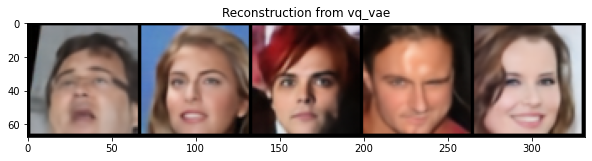

In [ ]:
#@title Compare Reconstruction 

num_imgs = 5 #@param {type:"slider", min:1, max:20, step:1}
plot_reconstruction(vaes, batch, num_of_samples=num_imgs)

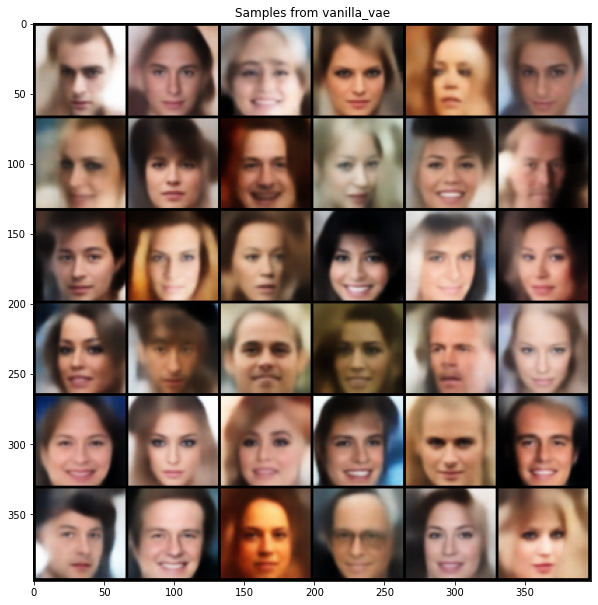

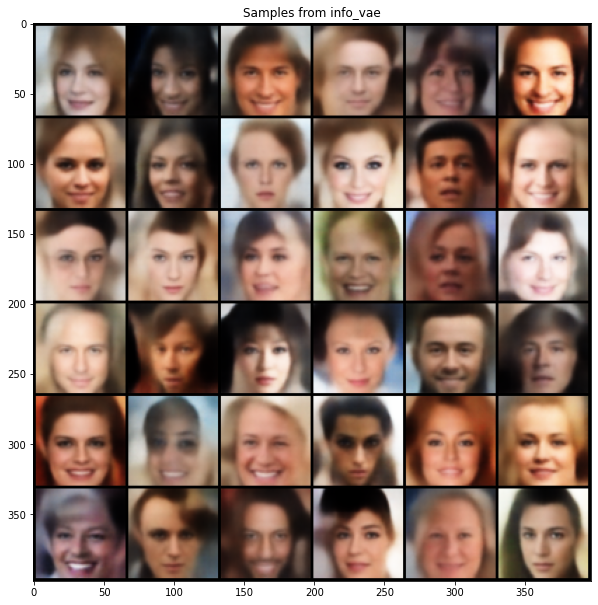

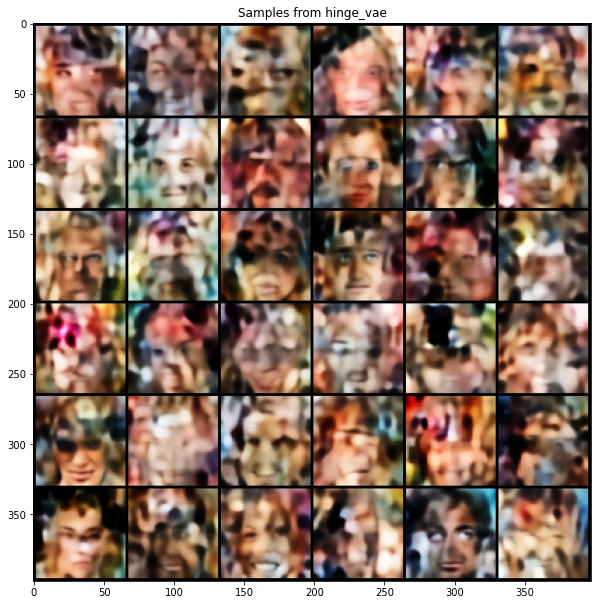

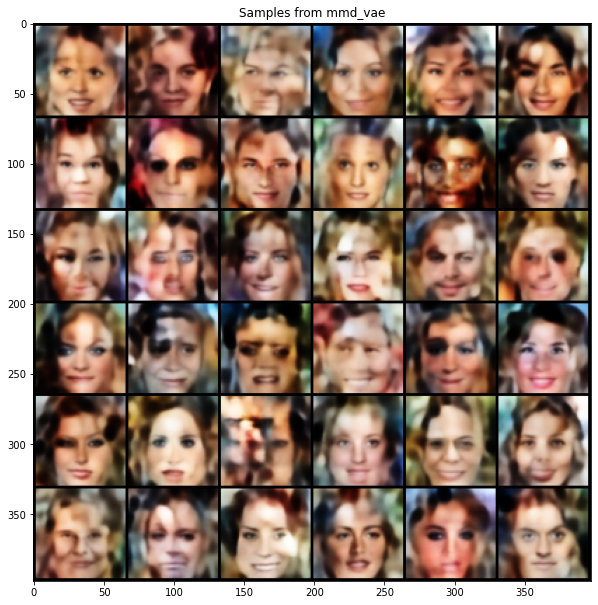

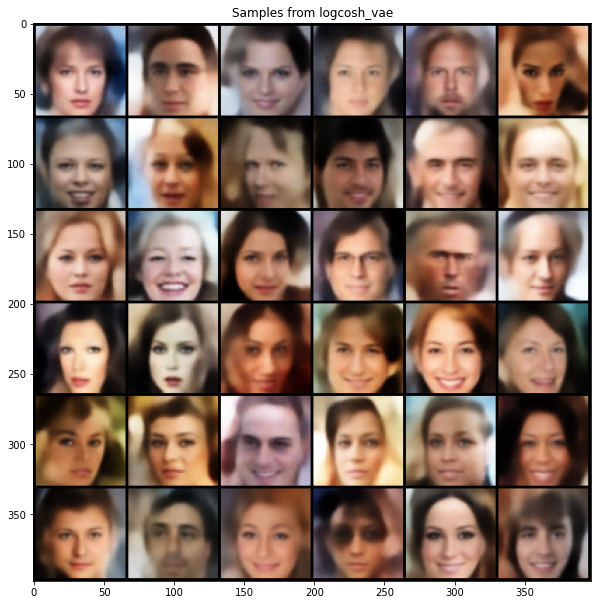

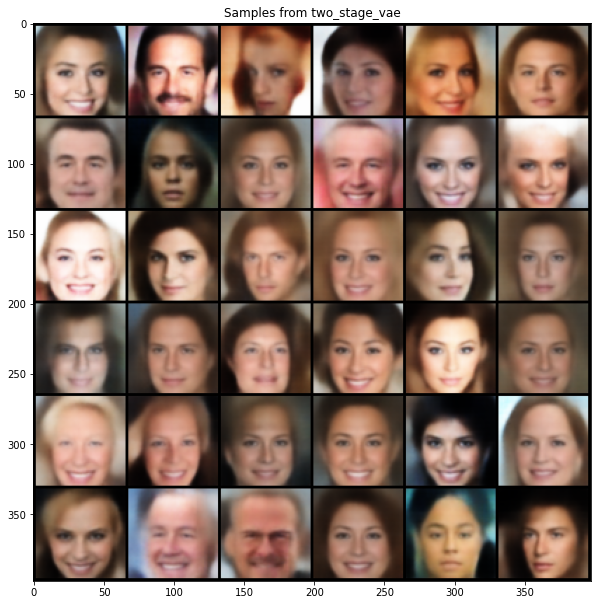

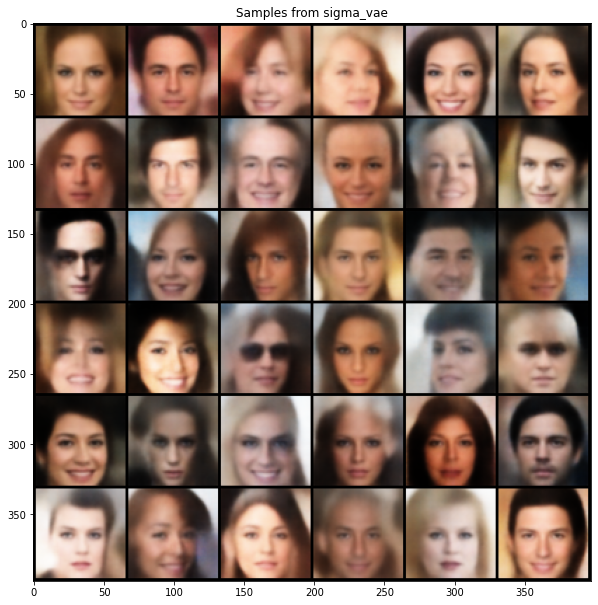

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


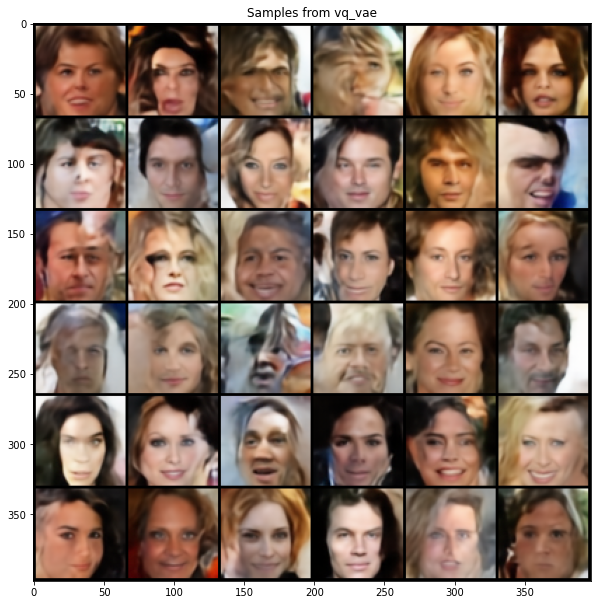

In [ ]:
#@title Compare Samples
vaes = make_and_load_models(models_to_compare, use_gpu = True)

num_imgs = 36 #@param  {type:"slider", min:1, max:100, step:1}
num_of_images_per_row = 6 #@param  {type:"slider", min:1, max:100, step:1}

plot_samples(vaes, num=num_imgs, num_of_images_per_row=num_of_images_per_row)

# Interpolation

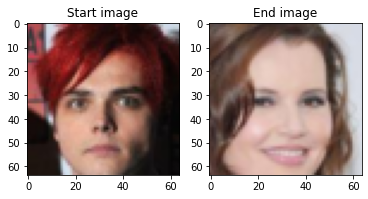

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


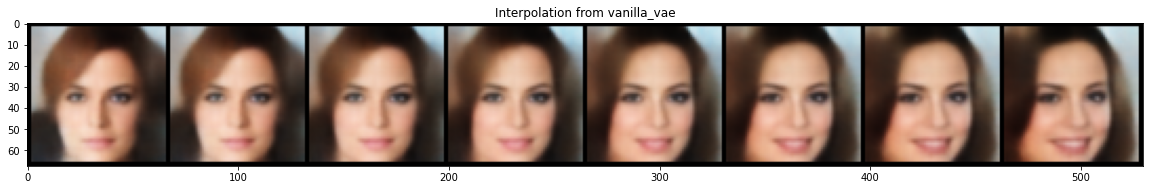

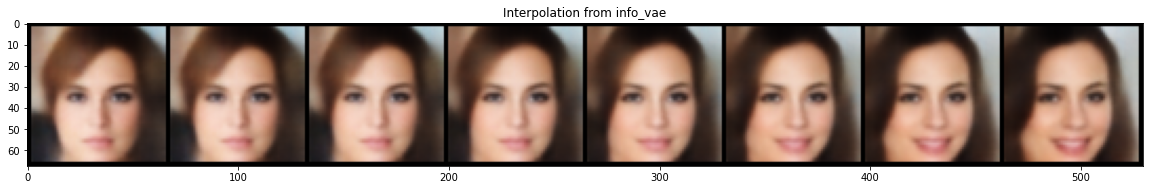

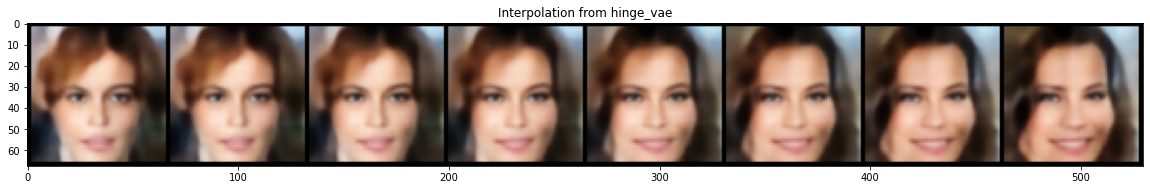

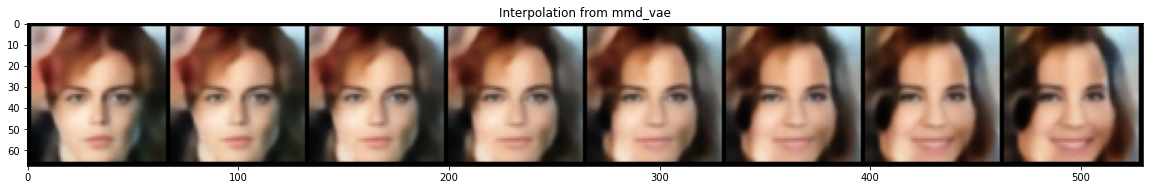

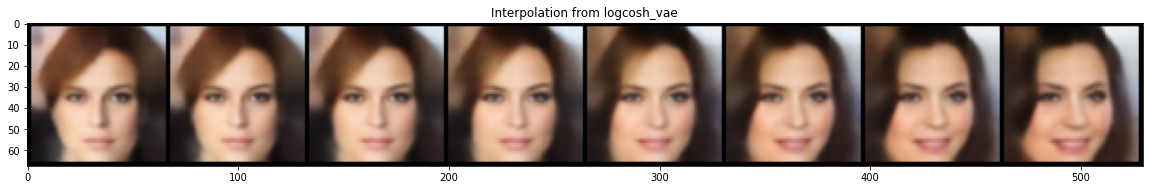

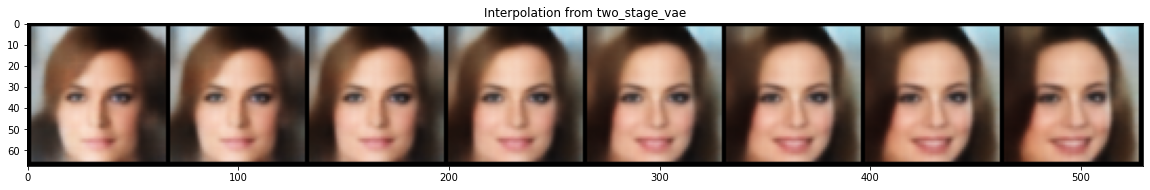

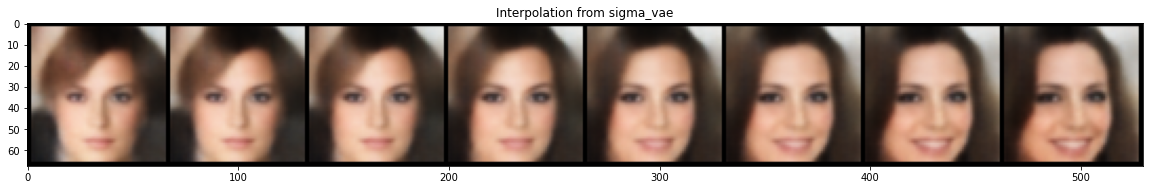

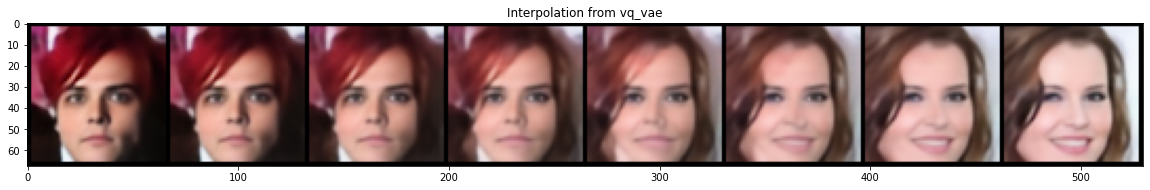

In [ ]:
from einops import rearrange
feature_of_interest="Male"
vec3, male, female = vector_of_interest(vaes[0], batch, feature_of_interest)

start_img = torch.reshape(male[1], [1, 3, 64, 64])
end_img = torch.reshape(female[1], [1, 3, 64, 64])

fig , axs = plt.subplots(1,2)
axs[0].set_title("Start image")
axs[0].imshow(rearrange(start_img, "b c h w -> h w (c b)"))
axs[1].imshow(rearrange(end_img, "b c h w -> h w (c b)"))
axs[1].set_title("End image")
plt.show()

for vae in vaes:
  plt.figure(figsize=(20,10))
  plt.title(f"Interpolation from {vae.model_name}")
  arr = get_imrange(vae.decode, vae.det_encode(start_img), vae.det_encode(end_img), nums=8, interpolation="linear")
  plt.imshow(arr)